In [1]:
import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'biomedical-text-publication-classification:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F2389764%2F4033428%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240405%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240405T071249Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D2b9cd6dc1432914a642a8fa5ef8cfca51f395ac29f661681692ea0a528ffec3704c10089cf476d0c67bfae12850404a7bee8d816cc494103dab22fc8e3fa013ec0383fc8a92d51b38eb1ba0625285dbd4903bb81e7818f18b4d03a3e72662f96f8b35a91b5ecc7441d995dcd49608b84e4bc002f88370b93d7f396f2b01fcf7578b1245ec4b1012b4a3b72f48bb103d8fc427d80d2a40f7b088125dc65f8888f7c2af3b42fb1525519ad3463d849927b48f1b94fca032e05cfabef138559b0e7cb9dffd49d66ac7a354faa2ef62f33a7f6f862a1895f072f2af81faf6aa22fef015ab0708773fd265644fa4adf7343833a4ef2729a4100543deeba5237e9c645'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 58651964 bytes downloaded
Downloaded and uncompressed: biomedical-text-publication-classification
Data source import complete.


In [2]:

import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import LSTM, GRU, SimpleRNN, Embedding
from tensorflow.keras.layers import Dense, Input, GlobalMaxPool1D
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense,Input,GlobalMaxPooling1D
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Embedding
from tensorflow.keras.models import Model
from tensorflow.keras.losses import SparseCategoricalCrossentropy

**Cancer Dataset**

In this project, I am employing two different models: CNN and RNN (LSTM), to analyze descriptions provided by doctors related to three different types of cancer.

Overall, the dataset contains 7000 entries. However, I have chosen to work with only 4000 entries to expedite the training process.

The final conclusions are as follows:

    Accuracy for CNN: 99%
    Accuracy for LSTM: 95%

It's evident that the CNN model outperforms LSTM in text predictions.

In [3]:
df = pd.read_csv('/kaggle/input/biomedical-text-publication-classification/alldata_1_for_kaggle.csv', header = None, encoding='latin1')

df.head()


,0,1,2
0,NaN,0,a
1,0.0,Thyroid_Cancer,Thyroid surgery in children in a single insti...
2,1.0,Thyroid_Cancer,""" The adopted strategy was the same as that us..."
3,2.0,Thyroid_Cancer,coronary arterybypass grafting thrombosis ï¬b...
4,3.0,Thyroid_Cancer,Solitary plasmacytoma SP of the skull is an u...


In [4]:
df = df[[1,2]]

In [5]:
df.head()

,1,2
0,0,a
1,Thyroid_Cancer,Thyroid surgery in children in a single insti...
2,Thyroid_Cancer,""" The adopted strategy was the same as that us..."
3,Thyroid_Cancer,coronary arterybypass grafting thrombosis ï¬b...
4,Thyroid_Cancer,Solitary plasmacytoma SP of the skull is an u...


In [6]:
df.columns=['labels','text']

In [7]:
df.head()

,labels,text
0,0,a
1,Thyroid_Cancer,Thyroid surgery in children in a single insti...
2,Thyroid_Cancer,""" The adopted strategy was the same as that us..."
3,Thyroid_Cancer,coronary arterybypass grafting thrombosis ï¬b...
4,Thyroid_Cancer,Solitary plasmacytoma SP of the skull is an u...


In [8]:
df.isnull().sum()

labels    0
text      0
dtype: int64

In [9]:
print(len(df))

7571


In [10]:
df = df.sample(4000)

In [11]:
df.sample(10)

,labels,text
2643,Thyroid_Cancer,EpidemiologyEPIDEMIOLOGICAL SCIENCERisk factor...
617,Lung_Cancer,"""The amount of microvasculature measured by LV..."
1631,Thyroid_Cancer,Signal Transduction and Targeted Therapywwwnat...
1522,Thyroid_Cancer,Journal of International Medical Research  Th...
1508,Colon_Cancer,purposeconjunctival squamous cell carcinoma sc...
7139,Thyroid_Cancer,Rheumatoid arthritis RA is a systemic chronic...
2998,Colon_Cancer,collagen triple helix repeat containing1 cthrc...
6078,Thyroid_Cancer,"""Early detection of capecitabineresistance cou..."
3100,Thyroid_Cancer,"""Cellular recognition of microbial DNA is an e..."
36,Thyroid_Cancer,"""Nonsmall cell lung cancer is the most common ..."


In [12]:
df['targets'] = df['labels'].astype('category').cat.codes

In [13]:
df.sample(10)

,labels,text,targets
3384,Colon_Cancer,""" deregulated circular rnas circrnas are asso...",1
2952,Colon_Cancer,mgat5 knockout ko in hek293 cells induces me...,1
4200,Thyroid_Cancer,Understanding of the RelevantRole of LINE1 Ret...,3
4129,Thyroid_Cancer,Genomic characterization of malignant progress...,3
5074,Colon_Cancer,environmental exposure to arsenite as3 has a s...,1
248,Thyroid_Cancer,"""Pharyngitis Tonsillitis Deep learning Smartph...",3
4576,Thyroid_Cancer,"""Sintilimab blocks the interaction between pro...",3
5613,Thyroid_Cancer,Paired box protein8 PAX8 immunohistochemical e...,3
1227,Thyroid_Cancer,"""enzymatic cascade for posttranslational prote...",3
2974,Colon_Cancer,"""melatonin is a sleepregulating hormone create...",1


In [14]:
df['labels'].value_counts()

labels
Thyroid_Cancer    1487
Colon_Cancer      1380
Lung_Cancer       1132
0                    1
Name: count, dtype: int64

In [15]:
K = df['targets'].max() + 1
K

4

In [16]:
from sklearn.model_selection import train_test_split

random_seed = 42

df_train, df_test = train_test_split(df, test_size=0.3, random_state=random_seed)

In [17]:
MAX_VOCAB_SIZE = 2000
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)

tokenizer.fit_on_texts(df_train['text'])

sequences_train = tokenizer.texts_to_sequences(df_train['text'])
sequences_test = tokenizer.texts_to_sequences(df_test['text'])

In [18]:
word2idx = tokenizer.word_index
V = len(word2idx)
print(f'Found unique words: {V}')

Found unique words: 202225


In [19]:
data_train = pad_sequences(sequences_train)
print(f'Shape of data train tensor: {data_train.shape}')

Shape of data train tensor: (2800, 4296)


In [20]:
data_train

array([[   0,    0,    0, ...,  110,  287,  353],
       [   0,    0,    0, ..., 1353,  349,  349],
       [   0,    0,    0, ...,    4,   86,   56],
       ...,
       [   0,    0,    0, ...,   39,  452,  565],
       [   0,    0,    0, ...,    1,    2,  201],
       [   0,    0,    0, ...,   43, 1083,    1]], dtype=int32)

In [21]:
T = data_train.shape[1]
T

4296

In [22]:
data_test = pad_sequences(sequences_test, maxlen=T)
print(f'Shape of data test tensor: {data_test.shape}')

Shape of data test tensor: (1200, 4296)


In [24]:
# Creating the CNN model

D = 30

i = Input(shape=(T,))
x = Embedding(V+ 1 ,D)(i)
x = Conv1D(32,2, strides=1 ,activation='relu')(x)
x = MaxPooling1D(3)(x)
x = Conv1D(64,3, activation='relu')(x)
x = GlobalMaxPooling1D()(x)
x = Dense(K)(x) # K is the total of news's labels

model = Model(i,x)

In [25]:
model.compile(
    loss=SparseCategoricalCrossentropy(from_logits=True),
    optimizer='adam',
    metrics=['accuracy']
)

print('Training the model...')
r = model.fit(
    data_train,
    df_train['targets'],
    epochs = 20,
    validation_data=(data_test, df_test['targets'])
)

Training the model...
Epoch 1/20
88/88 [==============================] - 28s 297ms/step - loss: 1.1206 - accuracy: 0.4571 - val_loss: 0.8208 - val_accuracy: 0.7150
Epoch 2/20
88/88 [==============================] - 25s 289ms/step - loss: 0.5759 - accuracy: 0.7064 - val_loss: 0.5060 - val_accuracy: 0.8100
Epoch 3/20
88/88 [==============================] - 25s 282ms/step - loss: 0.4434 - accuracy: 0.8196 - val_loss: 0.4077 - val_accuracy: 0.9033
Epoch 4/20
88/88 [==============================] - 25s 286ms/step - loss: 0.3046 - accuracy: 0.9279 - val_loss: 0.1985 - val_accuracy: 0.9525
Epoch 5/20
88/88 [==============================] - 26s 295ms/step - loss: 0.1189 - accuracy: 0.9761 - val_loss: 0.0965 - val_accuracy: 0.9758
Epoch 6/20
88/88 [==============================] - 25s 286ms/step - loss: 0.0561 - accuracy: 0.9900 - val_loss: 0.0627 - val_accuracy: 0.9858
Epoch 7/20
88/88 [==============================] - 24s 270ms/step - loss: 0.0328 - accuracy: 0.9946 - val_loss: 0.0436 

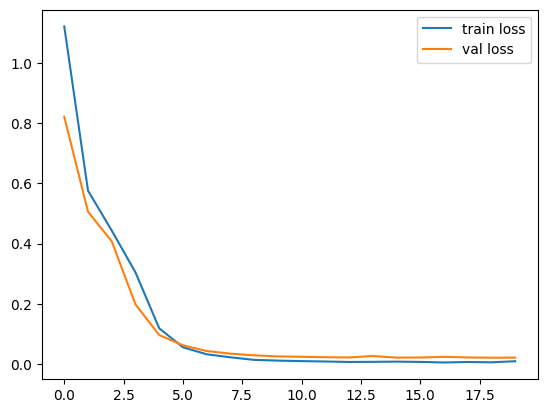

In [26]:
# Checking loss per itartion
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend();

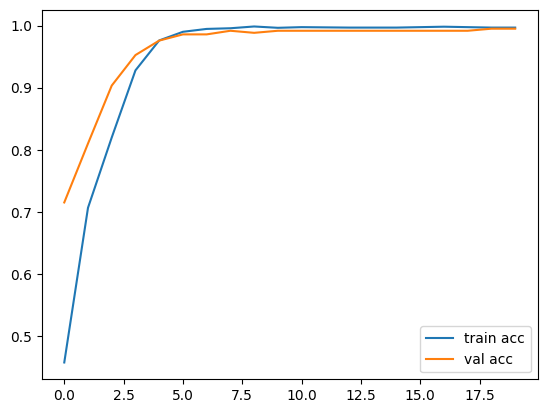

In [27]:
# Plot accuracy per iteration
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend();

In [28]:
from sklearn.metrics import classification_report

predictions = model.predict(data_test)
y_pred = np.argmax(predictions, axis=1)

y_true = df_test['targets']

report = classification_report(y_true, y_pred)
print(report)


38/38 [==============================] - 3s 56ms/step
              precision    recall  f1-score   support

           1       0.99      0.99      0.99       411
           2       1.00      0.99      1.00       326
           3       0.99      1.00      1.00       463

    accuracy                           0.99      1200
   macro avg       1.00      0.99      0.99      1200
weighted avg       1.00      0.99      0.99      1200



In [29]:
classes = df['targets'].unique()

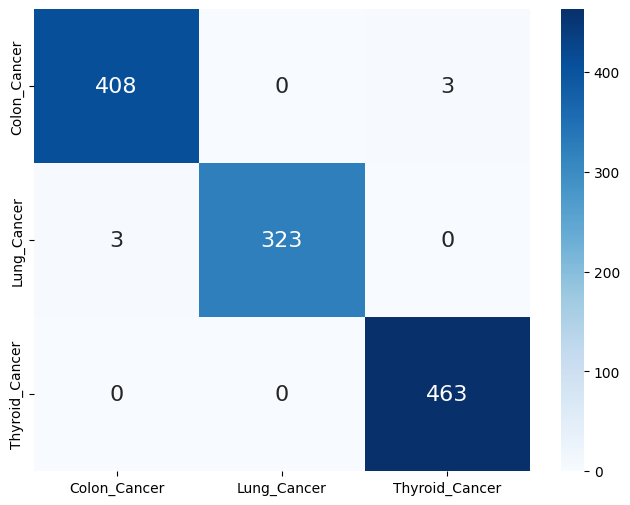

In [30]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

label_mapping = {
    0: 'Colon_Cancer',
    1: 'Lung_Cancer',
    2: 'Thyroid_Cancer'

}
marks = np.arange(len(label_mapping))

cm = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cm, index=[label_mapping[i] for i in label_mapping] , columns = [label_mapping[i] for i in label_mapping])

plt.figure(figsize=(8, 6))
plt.xlabel('Predicted')
plt.ylabel('True')
sns.heatmap(df_cm, annot=True, annot_kws={"size": 16}, fmt='d', cmap='Blues')

plt.show()

In [31]:
# Creating the model for RNN (LSTM)

i = Input(shape=(T,)) # T = Sequence Length
x = Embedding(V+1,D)(i) # symbolic representation of the input data that will be passed through the layers of the neural network
x = LSTM(32, return_sequences=True)(x)
x = GlobalMaxPool1D()(x)
x = Dense(K)(x)

model = Model(i,x)


In [ ]:
model.compile(
  loss=SparseCategoricalCrossentropy(from_logits=True),
  optimizer='adam',
  metrics=['accuracy']
)


print('Training model...')

r_rnn = model.fit(
  data_train,
  df_train['targets'],
  epochs=5,
  validation_data=(data_test, df_test['targets'])
)

Training model...
Epoch 1/5
88/88 [==============================] - 430s 5s/step - loss: 1.1762 - accuracy: 0.3589 - val_loss: 1.0613 - val_accuracy: 0.3858
Epoch 2/5
88/88 [==============================] - 419s 5s/step - loss: 0.9449 - accuracy: 0.5761 - val_loss: 0.7929 - val_accuracy: 0.8100
Epoch 3/5
88/88 [==============================] - 419s 5s/step - loss: 0.7055 - accuracy: 0.8229 - val_loss: 0.6365 - val_accuracy: 0.8383
Epoch 4/5
88/88 [==============================] - 419s 5s/step - loss: 0.5797 - accuracy: 0.8354 - val_loss: 0.5437 - val_accuracy: 0.8417
Epoch 5/5
78/88 [=========================>....] - ETA: 45s - loss: 0.5412 - accuracy: 0.8297

In [34]:
predictions = model.predict(data_test)
y_pred = np.argmax(predictions, axis=1)  # Convert logits to class labels

# Get true labels
y_true = df_test['targets']

# Generate classification report
report = classification_report(y_true, y_pred)
print(report)

38/38 [==============================] - 16s 402ms/step
              precision    recall  f1-score   support

           1       0.72      0.89      0.80       411
           2       0.97      0.97      0.97       326
           3       0.89      0.70      0.78       463

    accuracy                           0.84      1200
   macro avg       0.86      0.85      0.85      1200
weighted avg       0.85      0.84      0.84      1200



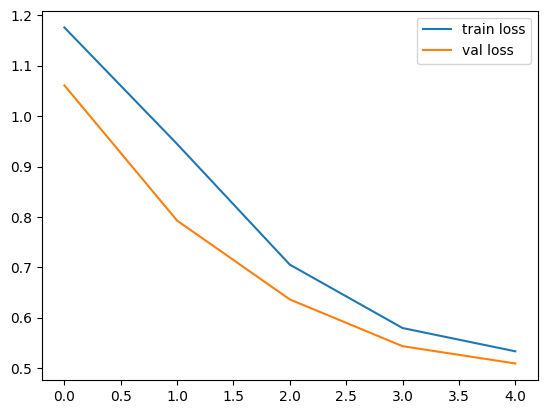

In [35]:
# Checking loss per itartion
plt.plot(r_rnn.history['loss'], label='train loss')
plt.plot(r_rnn.history['val_loss'], label='val loss')
plt.legend();

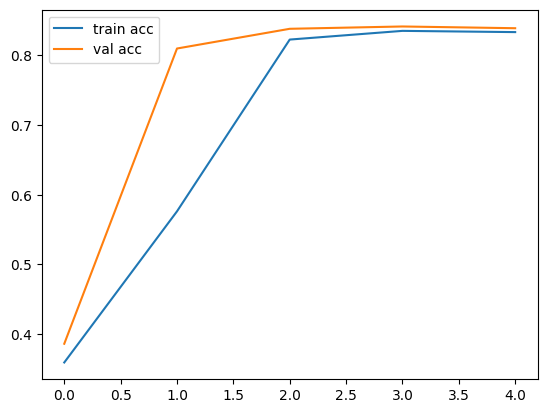

In [36]:
# Plot accuracy per iteration
plt.plot(r_rnn.history['accuracy'], label='train acc')
plt.plot(r_rnn.history['val_accuracy'], label='val acc')
plt.legend();

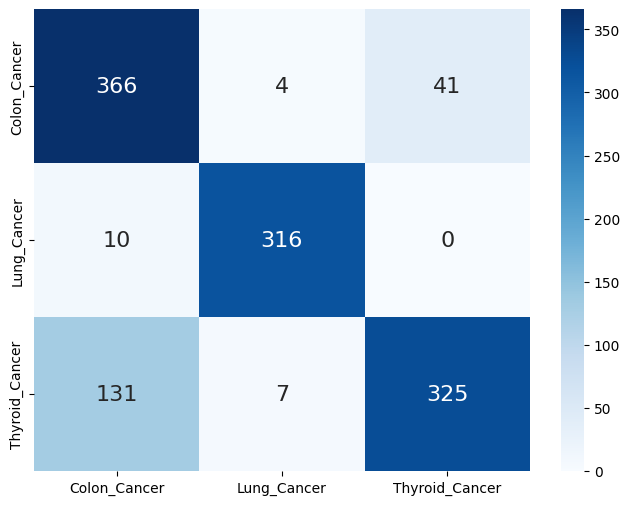

In [37]:
label_mapping = {
    0: 'Colon_Cancer',
    1: 'Lung_Cancer',
    2: 'Thyroid_Cancer'

}
marks = np.arange(len(label_mapping))

cm = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cm, index=[label_mapping[i] for i in label_mapping] , columns = [label_mapping[i] for i in label_mapping])

plt.figure(figsize=(8, 6))
plt.xlabel('Predicted')
plt.ylabel('True')
sns.heatmap(df_cm, annot=True, annot_kws={"size": 16}, fmt='d', cmap='Blues')

plt.show()